# Useful Resources
JAX Beginner Guide: https://docs.jax.dev/en/latest/beginner_guide.html#beginner-guide

Deep Learning Tutorials: https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

JAX GitHub: https://github.com/jax-ml/jax

JAX Libraries: https://github.com/n2cholas/awesome-jax

Flax: https://flax.readthedocs.io/en/latest/

XLA: https://openxla.org/xla

Autodiff in JAX: https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html

Visualizing Graphs: https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html

LAX: https://docs.jax.dev/en/latest/jax.lax.html

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import matplotlib as mpl
import numpy as np
import jax
import sys

np.random.seed(42)

In [3]:
np.__version__, jax.__version__,  mpl.__version__, sys.version

('2.3.3',
 '0.4.30',
 '3.9.4',
 '3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]')

# Change floating point precision

In [4]:
jax.config.update("jax_enable_x64", False) # Change to 'True'

# What devices are available?

If the GPU is available on your device JAX, will automatically us that as its default device

In [5]:
jax.devices()

[cuda(id=0)]

# NumPy vs. JAX

JAX arrays are backed by XLA (Accelerated Linear Algebra) which is a compiler that optimizes operations commonly used in data science involving tensors

In [6]:
ones_jnp = jnp.ones(shape=(3,2), dtype=jnp.float32)
ones_jnp.__class__, type(ones_jnp)

2025-09-25 14:32:54.152107: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.7 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

In [7]:
ones_np = np.ones(shape=(3,2))
ones_np.__class__, type(ones_np)

(numpy.ndarray, numpy.ndarray)

# Operations between NumPy arrays and JAX arrays

In [8]:
ones_jnp + ones_np

Array([[2., 2.],
       [2., 2.],
       [2., 2.]], dtype=float32)

In [9]:
type(ones_jnp + ones_np)

jaxlib.xla_extension.ArrayImpl

# Unless you give priority to NumPy the result is usually a JAX array

In [10]:
np.add(ones_jnp, ones_np), type(np.add(ones_jnp, ones_np))

(array([[2., 2.],
        [2., 2.],
        [2., 2.]]),
 numpy.ndarray)

# What if we want to perform computations or load data on the CPU?

In [11]:
ones_jnp.devices()

{cuda(id=0)}

# `jax.device_get`: GPU to CPU


In [12]:
ones_jnp_cpu = jax.device_get(ones_jnp)
type(ones_jnp_cpu)

numpy.ndarray

# `jax.device_put`: CPU to GPU

In [13]:
ones_jax_gpu = jax.device_put(ones_jnp_cpu)
type(ones_jax_gpu), ones_jax_gpu.devices()

(jaxlib.xla_extension.ArrayImpl, {cuda(id=0)})

# Modifying JAX and NumPy arrays

In [14]:
np_arange = np.arange(0, 8, 2)
np_arange

array([0, 2, 4, 6])

In [15]:
np_arange[-1] = 0.1
np_arange

array([0, 2, 4, 0])

# What went wrong here?

In [16]:
np_arange.dtype, type(0.1)

(dtype('int64'), float)

In [17]:
np_arange = np.arange(0, 8, 2, dtype=np.float32)
np_arange

array([0., 2., 4., 6.], dtype=float32)

In [18]:
np_arange[-1] = 0.1
np_arange

array([0. , 2. , 4. , 0.1], dtype=float32)

In [19]:
jnp_arange = jnp.arange(0, 8, 2, dtype=jnp.float32)
jnp_arange

Array([0., 2., 4., 6.], dtype=float32)

In [20]:
jnp_arange[-1] = 0.1

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

### JAX arrays are immutable meaning we cannot modify them in-place like we can in NumPy. This is done because JAX is designed to operate in a functional programming type of way where pretty much everything is done in terms of functions. Functions should be pure making it easier to track and follow what they are doing. Functions generally should not depend on things like arrays that are not apart of their inputs or are defined outside (avoid side-effects)!

In [21]:
jnp_arange = jnp_arange.at[-1].set(0.1)
jnp_arange

Array([0. , 2. , 4. , 0.1], dtype=float32)

# Random Numbers and distributions

JAX wants things to be pure, with no side-effects and high reproducibility. This is desirable in context where we deal with random numbers like in machine learinng

In [22]:
np_random_num1 = np.random.normal()
np_random_num2 = np.random.normal()

In [23]:
np_random_num1, np_random_num2

(0.4967141530112327, -0.13826430117118466)

This is not ideal for ease of reproducibility. We are calling the same function, which the same inputs (none) and getting completely different results.

In [24]:
key = jax.random.PRNGKey(42)
key

Array([ 0, 42], dtype=uint32)

In [25]:
jax_random_num1 = jax.random.normal(key)
jax_random_num2 = jax.random.normal(key)

In [26]:
jax_random_num1.item(), jax_random_num2.item()

(-0.1847117692232132, -0.1847117692232132)

Each time we sample the normal though we wouldn't expect to get the same exact output. Remember, these functions should have no side-effects, the same input means the same output

To generate new or "unique" samples we use a new key that is dependent on the previous key

In [27]:
key, subkey1, subkey2 = jax.random.split(key, num=3)
key, subkey1, subkey2

(Array([3134548294, 3733159049], dtype=uint32),
 Array([3746501087,  894150801], dtype=uint32),
 Array([ 801545058, 2363201431], dtype=uint32))

In [28]:
jax_random_num1 = jax.random.normal(subkey1)
jax_random_num2 = jax.random.normal(subkey2)

jax_random_num1.item(), jax_random_num2.item()

(0.10796153545379639, -1.2226542234420776)

# Computational Graphs

In [29]:
def my_func(x):
    x = x + 2
    x = x / 2
    x = x.sum()
    return x

In [30]:
inp = jnp.arange(2.0)
inp

Array([0., 1.], dtype=float32)

In [31]:
my_func(inp)

Array(2.5, dtype=float32)

In [32]:
jax.make_jaxpr(my_func)(inp)

{ lambda ; a:f32[2]. let
    b:f32[2] = add a 2.0
    c:f32[2] = div b 2.0
    d:f32[] = reduce_sum[axes=(0,)] c
  in (d,) }

# Derivatives

In [33]:
def polynomial(x):
    return x**2 + 4*x + 5

In [34]:
inp = 1.0
jax.make_jaxpr(polynomial)(inp)

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=2] a
    c:f32[] = mul 4.0 a
    d:f32[] = add b c
    e:f32[] = add d 5.0
  in (e,) }

If the output of our function is a scalar then use ```jax.grad```

In [35]:
dy_dx = jax.grad(polynomial, argnums=0)
dy_dx(inp).item()

6.0

We can also look at the derivatives graph

In [36]:
jax.make_jaxpr(dy_dx)(inp)

{ lambda ; a:f32[]. let
    b:f32[] = integer_pow[y=2] a
    c:f32[] = integer_pow[y=1] a
    d:f32[] = mul 2.0 c
    e:f32[] = mul 4.0 a
    f:f32[] = add b e
    _:f32[] = add f 5.0
    g:f32[] = mul 4.0 1.0
    h:f32[] = mul 1.0 d
    i:f32[] = add_any g h
  in (i,) }

To take derivatives with respect to other arguments

In [37]:
def polynomial_2d(x, y):
    return x**2 + y**2

In [38]:
inp_x = 2.0
inp_y = 1.0

df_dx = jax.grad(polynomial_2d, argnums=0)(inp_x, inp_y)
df_dy = jax.grad(polynomial_2d, argnums=1)(inp_x, inp_y)

df_dx.item(), df_dy.item()

(4.0, 2.0)

Let's say we want to get both in one shot

In [39]:
df_dx, df_dy = jax.grad(polynomial_2d, argnums=(0,1))(inp_x, inp_y)
df_dx.item(), df_dy.item()

(4.0, 2.0)

To get the value of the function and derivative

In [40]:
value, grad = jax.value_and_grad(polynomial_2d, argnums=(0,1))(inp_x, inp_y)

Alternatively

In [41]:
value, (df_dx, df_dy) = jax.value_and_grad(polynomial_2d, argnums=(0,1))(inp_x, inp_y)
value.item(), df_dx.item(), df_dy.item()

(5.0, 4.0, 2.0)

What if our function has more than one output

In [42]:
def new_func(x,y):
    z = x + y
    return x**2 + y**2, z

In [43]:
(value, aux), grad = jax.value_and_grad(new_func, argnums=0, has_aux=True)(inp_x, inp_y)
value.item(), aux.item(), grad.item()

(5.0, 3.0, 4.0)

Second, third, fourth, ... derivative? Stack them!

In [44]:
def ex_func(x):
    return x**5

grad_fn = jax.grad
grad_fn(grad_fn(grad_fn(grad_fn(grad_fn(ex_func)))))(454.0211).item() # d^n/dx^n (x^n) = n! (doesnt depend on x)

120.0

In [45]:
grad_fn(grad_fn(grad_fn(grad_fn(grad_fn(grad_fn(ex_func))))))(9262.0371).item() # d^n/dx^n (x^{n+j}) = 0, j>1

0.0

Much of the time in machine learning we end up taking derivatives of functions that output scalar but what if our output is not? This calls for the Jacobian

In [46]:
def vector_func(vector):
    new_vector = 3*vector
    result = new_vector + 2
    return result

In [47]:
inp_vector = jnp.array([-1.0, 3.0])

In [48]:
jax.grad(vector_func)(inp_vector)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

In [49]:
jax.jacobian(vector_func)(inp_vector)

Array([[3., 0.],
       [0., 3.]], dtype=float32)

The Jacobian is given by
$$
\nabla \mathbf{f} =
\begin{bmatrix}
    \dfrac{\partial \mathbf{f}}{\partial x_1} & \cdots & \dfrac{\partial \mathbf{f}}{\partial x_n}
\end{bmatrix} =
\begin{bmatrix}
    \nabla^T f_1 \\
    \vdots \\
    \nabla^T f_m
\end{bmatrix} =
\begin{bmatrix}
    \dfrac{\partial f_1}{\partial x_1} & \cdots & \dfrac{\partial f_1}{\partial x_n} \\
    \vdots & \ddots & \vdots \\
    \dfrac{\partial f_m}{\partial x_1} & \cdots & \dfrac{\partial f_m}{\partial x_n}
\end{bmatrix}
$$
In our case
$$ f(\mathbf{X}) = 3X + 2, \quad \mathbf{X}\in\mathbb{R}^{2}$$

$$ \mathbf{f} = [f_1, f_2]^T, \quad \mathbf{X} = [x_1, x_2]^T$$

The first element of $\mathbf{f}$ is not influenced by the second element of $\mathbf{X}$ and vice-versa so the anti-diagonal is zero  

$$
\nabla \mathbf{f} =
\begin{bmatrix}
    \dfrac{\partial f_1}{\partial x_1} & \dfrac{\partial f_1}{\partial x_2} \\
    \dfrac{\partial f_2}{\partial x_1} & \dfrac{\partial f_2}{\partial x_2}
\end{bmatrix} =
\begin{bmatrix}
    3 & 0 \\
    0 & 3
\end{bmatrix}
$$

The powerful part about this is that no matter how comlicated our function, as long as we have the function we can take its derivative

$$
\begin{gather}f(x, y, z, w, v) = \\\dfrac{\sin\left(e^{x^2 + y^2} + \cosh(wz)\right) + \log\left(1 + w^2 \cosh(z) + v^3\right) - \dfrac{x^3 y^2}{z + e^{-w} + \tan(v)} + \arctan\left(\dfrac{y}{x + z^2 + \sinh(vw)}\right) e^{-\sin(w) + \cos(yz)} + \dfrac{\ln(1 + x^2 + y^2)}{1 + v^4 w^2}}{\dfrac{\text{erf}(xz)}{z^y}\left(1 + (5xy)^2 + y^2 + z^2 + w^2 + v^2 + e^{-|x+y+z|} + \dfrac{\cosh(w)}{\log_2\left(\frac{x}{y}\right)}\right)}
\end{gather}
 $$

In [50]:
def crazy_function(x, y, z, w, v):
    numerator = (
        jnp.sin(jnp.exp(x**2 + y**2) + jnp.cosh(w * z)) +
        jnp.log(1 + w**2 * jnp.cosh(z) + v**3) -
        (x**3 * y**2) / (z + jnp.exp(-w) + jnp.tan(v)) +
        jnp.arctan(y / (x + z**2 + jnp.sinh(v * w))) * jnp.exp(-jnp.sin(w) + jnp.cos(y * z)) +
        jnp.log(1 + x**2 + y**2) / (1 + v**4 * w**2)
    )

    denominator = jax.lax.erf(x*z)/(z**y) * \
                  (1 + (5*x*y)**2 + y**2 + z**2 + w**2 + v**2 + jnp.exp(-jnp.abs(x + y + z)) + (jnp.cosh(w) / (jnp.log2(x / y))))

    return numerator / denominator

vals = abs(jax.random.normal(jax.random.PRNGKey(3853), shape=(5,)))
derivative = jax.grad(crazy_function, argnums=(0,1,2,3,4))(*vals)

tuple(deriv.item() for deriv in derivative)

(-1.4099465608596802,
 -1.9902960062026978,
 -0.12008089572191238,
 -0.09395186603069305,
 0.015689322724938393)

How long does this take, how long would it take you?

In [51]:
%%timeit
jax.grad(crazy_function, argnums=(0,1,2,3,4))(*vals)

52.8 ms ± 747 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


What if we have several vectors we want to input and take the derivatives of

# JIT and vmap

JIT is a way of calling XLA to look at a function and optimize it

In [52]:
slow_function = jax.grad(crazy_function, argnums=(0,1,2,3,4))
fast_function = jax.jit(jax.grad(crazy_function, argnums=(0,1,2,3,4)))

In [53]:
slow_function(*vals), fast_function(*vals);

In [54]:
%%timeit
slow_function(*vals)

53.4 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%%timeit
fast_function(*vals)

106 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Generally you want to JIT your outer most function

Let's say we have a data set with a shape of $(B,N,d)$ and a function we want to evalute each of these examples on

In [56]:
def per_example_func(x):
    return jnp.sum(x, axis=-1)

B, N, d = 50, 100, 5

key = jax.random.PRNGKey(1)
data = jax.random.normal(key, shape=(B, N, d))

batched_func = jax.vmap(per_example_func, in_axes=0) # which axis are we vectorizing/looping over
batched_func(data).shape

(50, 100)

We have 50 examples, 100 data points and 5 dimensions. Across each point we sum the values across all dimension. We expect the ouptut to be $(B,N)$

In [57]:
def nonlinear_fn(x):
    return jnp.tanh(x) * jnp.sin(x) + jnp.cos(x**2)

B, d = 10, 5
key = jax.random.PRNGKey(1)
data = jax.random.normal(key, (B, d))

batched_jacobian = jax.vmap(jax.jacobian(nonlinear_fn), in_axes=0)
batched_jacobian(data).shape

(10, 5, 5)

We have 10 examples each with 5 dimensions. The jacobian evaluated at each of those points is (5,5). We expect the ouput to be $(B,d,d)$

vmap can also be stacked

In [58]:
B, N, d = 5, 20, 5
key = jax.random.PRNGKey(2)
data = jax.random.normal(key, (B, N, d))

In [59]:
# Vectorize over N
batched_jacobian = jax.vmap(jax.jacobian(nonlinear_fn), in_axes=0) # will gives us (N,d,d)

# Vectorize over B
final_jacobian = jax.vmap(batched_jacobian, in_axes=0) # will give us (B,N,d,d)
final_jacobian(data).shape

(5, 20, 5, 5)

Use vmap when needed i.e., vectorizing an operation you might turn to a for loop for (e.g. vectorizing a function over multiple inputs)

If you can right something as a for loop you can most likely implement it more efficiently with vmap or maybe even something like `jax.lax.scan`

```jax.vmap(fun, in_axes=0, out_axes=0)```

```fun```: function you are vectorizing

```in_axes```: which axes of you input to ```fun``` are you vectorizing

```out_axes```: where do you want the batched axis to end up

The length of `in_axes` is the number of function arguments

In [60]:
def multiply(x, y):
    return x * y

x = jnp.array((1.0, 3.0))

y = jnp.array((2.0, 4.0))

batched_multiply = jax.vmap(multiply, in_axes=(0,None))

result = batched_multiply(x, y)
print(result, result.shape)

[[ 2.  4.]
 [ 6. 12.]] (2, 2)


In [61]:
batched_multiply = jax.vmap(multiply, in_axes=(0,0))

result = batched_multiply(x, y)
print(result, result.shape)

[ 2. 12.] (2,)


# Using what we've learned

In [62]:
data.shape # (B, N, d)

(5, 20, 5)

In [63]:
def nonlinear_fn(x):
    return jnp.tanh(x) * jnp.sin(x) + jnp.cos(x**2)

per_example_jacobian = jax.jacobian(nonlinear_fn)

batched_jacobian = jax.vmap(jax.vmap(jax.jacobian(nonlinear_fn), in_axes=0), in_axes=0)

In [64]:
def loop_jacobian(data):
    jacobians = jnp.zeros((B, N, d, d))
    for b in range(B):
        for n in range(N):
            jacobians = jacobians.at[b, n].set(per_example_jacobian(data[b, n]))
    return jacobians

In [65]:
%%timeit
batched_jacobian(data).block_until_ready()

9.18 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%%timeit
loop_jacobian(data).block_until_ready()

719 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
jit_batched_jacobian = jax.jit(batched_jacobian)
jit_loop_jacobian = jax.jit(loop_jacobian)

_ = jit_batched_jacobian(data)
_ = jit_loop_jacobian(data)

In [68]:
%%timeit
jit_batched_jacobian(data).block_until_ready()

57 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
%%timeit
jit_loop_jacobian(data).block_until_ready()

236 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Rejection Sampling: Generating observations from a distribution

Say we have some distribution $p(x)$ (or even $\tilde{p}(x)$ which we want to sample from. However, $p(x)$ may be very complicated and so sampling from it may not be easy for possbile. We assume we can evaluted $p(x)$.

1. Choose a proposal distribution $q(x)$ which is easy to sample from such that $\exists c>0$ in which $c\cdot q(x)\geq \tilde{p}(x) ~ \forall x$.

2. Sample $x\sim q(x)$ and $y\sim U[0, c\cdot q(x)]$

If $y\leq \tilde{p}(x)$ then accept the sample else reject the sample.

Let $c = \max\left(\dfrac{\tilde{p}(x)}{q(x)}\right)$ because we want $c\geq\dfrac{\tilde{p}(x)}{q(x)}$ it will always be true that $~\text{max}\left(\dfrac{\tilde{p}(x)}{q(x)}\right)\geq\dfrac{\tilde{p}(x)}{q(x)}$.



In [70]:
from functools import partial
from jax.scipy.stats.norm import pdf as norm_pdf
import seaborn as sns

def p(x): # What we want to sample from or approximate samples from
    return norm_pdf(x, loc=30, scale=jnp.sqrt(10)) + norm_pdf(x, loc=80, scale=jnp.sqrt(20))

def q(x): # Proposal distribution
    return norm_pdf(x, loc=40, scale=50)

def rejection_step(carry, _):
    key, c = carry
    key, x_key, y_key = jax.random.split(key, 3)
    x_sample = 50 * jax.random.normal(x_key) + 40 # Sample x ~ q(x)
    y_sample = jax.random.uniform(y_key, minval=0, maxval=c * q(x_sample)) # sample y ~ U[-, c*q(x)]
    cond = y_sample <= p(x_sample) # Check condition
    x_sample = jnp.where(cond, x_sample, jnp.nan) # Mask out x if condition is not met
    return (key, c), x_sample

@partial(jax.jit, static_argnums=(2,))
def rejection_scan(key, c, num_samples):
    init_carry = (key, c)
    _, samples = jax.lax.scan(rejection_step, init_carry, None, length=num_samples)
    return samples

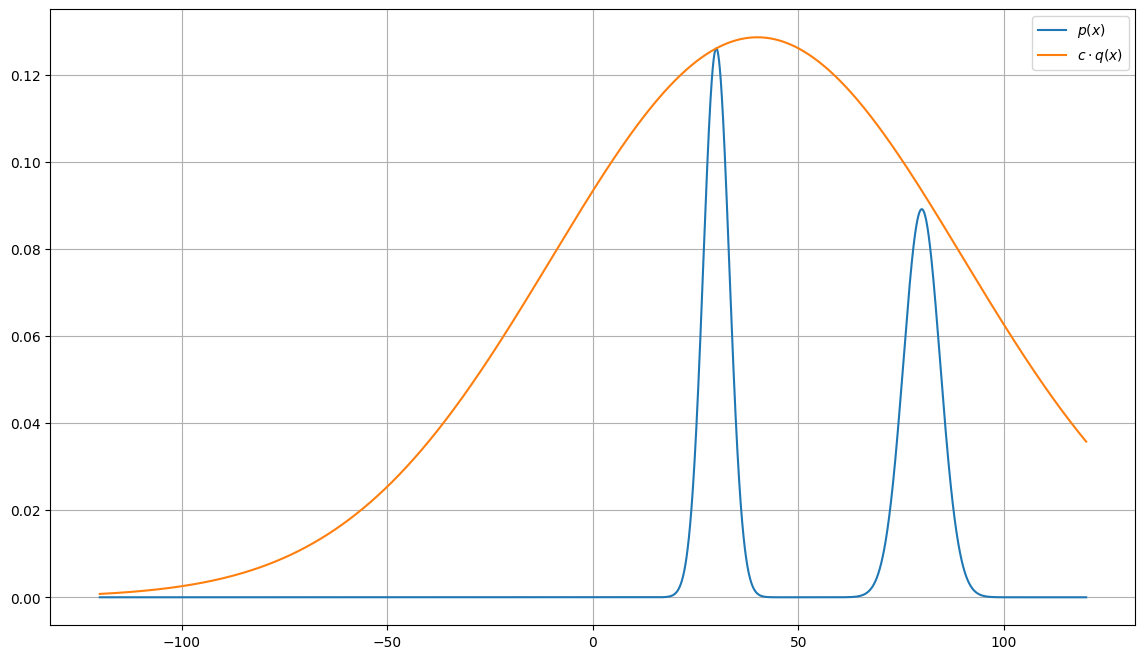

In [71]:
x_eval = jnp.linspace(-120, 120, 10000)
p_eval = p(x_eval)
q_eval = q(x_eval)
c = jnp.max(p_eval / q_eval)

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(x_eval, p_eval, label=r"$p(x)$")
ax.plot(x_eval, c * q_eval, label=r"$c\cdot q(x)$")
ax.grid()
ax.legend()
plt.show()

In [72]:
x_eval = jnp.linspace(-120, 120, 10000)
p_eval = p(x_eval)
q_eval = q(x_eval)
c = jnp.max(p_eval/q_eval)

num_samples = 100000

key = jax.random.PRNGKey(1)
rejection_samples = rejection_scan(key=key, c=c, num_samples=num_samples)
rejection_samples = rejection_samples[~jnp.isnan(rejection_samples)]
print(f"Rejection mean: {rejection_samples.mean()}")
print(f"Rejection var: {rejection_samples.var()}")

Rejection mean: 55.348594665527344
Rejection var: 639.3859252929688


Note the true mean is 55 and the true variance is 640

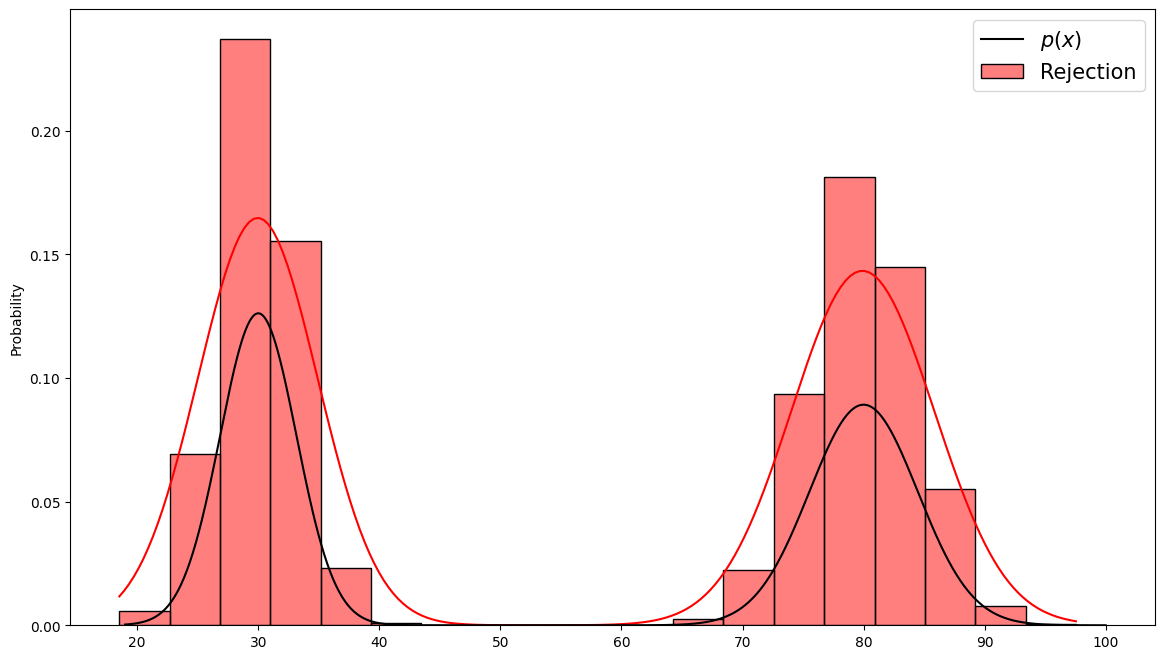

In [73]:
x_eval = jnp.linspace(19, 100, 1000)
p_eval = p(x_eval)

fig, ax = plt.subplots(figsize=(14,8))
sns.histplot(rejection_samples, kde=True, color="r", stat='probability', label="Rejection")
ax.plot(x_eval, p_eval, c="k", label="$p(x)$")
ax.legend(fontsize=15)
plt.show()

In [74]:
%%timeit
rejection_scan(key=key, c=c, num_samples=100000)

594 ms ± 643 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
def rejection_loop(key, c, num_samples):
  accepted_samples = []
  for _ in range(num_samples):
      key, x_key, y_key = jax.random.split(key, 3)
      x_sample = 50 * jax.random.normal(x_key) + 40
      y_sample = jax.random.uniform(y_key, minval=0, maxval=c * q(x_sample))
      if y_sample <= p(x_sample):
          accepted_samples.append(x_sample)
  accepted_samples = jnp.array(accepted_samples)
  return accepted_samples

In [76]:
%%timeit
rejection_loop(key=key, c=c, num_samples=150)

585 ms ± 6.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
